# Ignore this

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict

class PlotHelper():
    def __init__(self):
        self.reset()

    def reset(self):
        self._f = None
        self._ax = None
        self.kvals = defaultdict(list)

    def add(self, **kval):
        for k, v in kval.items():
            self.kvals[k].append(v)

    @property
    def fig(self):
        if self._f is None:
            self.new()
        return self._f

    @property
    def ax(self):
        if self._ax is None:
            self.new()
        return self._ax

    def new(self):
        self._f, self._ax = plt.subplots(1,1)
        plt.ion()
        self.fig.show()

    def show(self):
        names = []
        self.ax.clear()
        for k, v in self.kvals.items():
            names.append(k)
            self.ax.plot(v)
        self.ax.legend(names)
        self.fig.canvas.draw()

# Basic Example

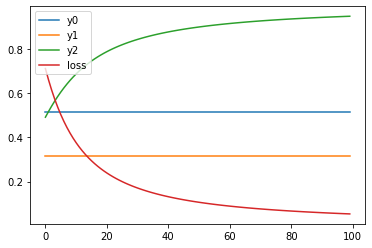

In [2]:
import torch
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, w=None):
        super().__init__()
        if w is not None:
            self.w = torch.nn.Parameter(torch.tensor(w).float().view(6, 1))
        else:
            self.w = torch.nn.Parameter(torch.rand(6, 1))

    def forward(self, x):
        return torch.matmul(self.w, x).view(3, 2)


net = Net()

opt = torch.optim.SGD(net.parameters(), lr=0.1)

plot = PlotHelper()

x = torch.tensor([1.])
y = torch.tensor([0, 0, 1])

for _ in range(100):
    opt.zero_grad()
    y_logit = net(x)
    loss = F.cross_entropy(y_logit[2:], y[2:])
    loss.backward()
    y_prob = torch.softmax(y_logit, dim=-1)
    plot.add(y0=y_prob[0,1].data, y1=y_prob[1,1].data, y2=y_prob[2,1].data, loss=loss.data)
    opt.step()

plot.show()


lambda y: ; return And(Not(Eq(y[[0]],y[[1]])),Not(Eq(y[[1]],y[[2]])))


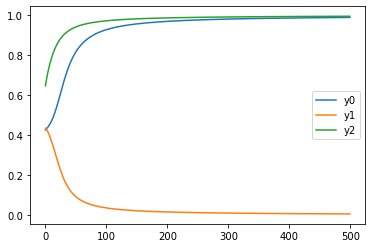

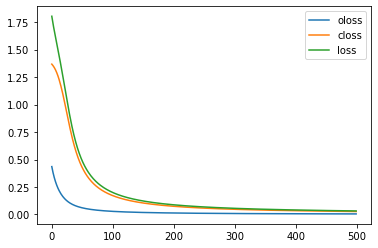

In [3]:
import torch
import itertools

from pylon.constraint import constraint
from pylon.brute_force_solver import *
from pylon.sampling_solver import *
from pylon.tnorm_solver import ProductTNormLogicSolver

net = Net()
opt = torch.optim.SGD(net.parameters(), lr=0.1)
plot = PlotHelper()
plot_loss = PlotHelper()


# y: 3, Bx3
def xor(y):
    # return (y[0] and not y[2]) or (not y[0] and y[2])
    return y[0]!=y[1] and y[1]!=y[2]
    # return any([y[i]==y[i-1] for i in range(10)])

# xor_cons = constraint(xor)
num_samples = 100
# xor_cons = constraint(xor, SamplingSolver(num_samples))
# xor_cons = constraint(xor, WeightedSamplingSolver(num_samples))
xor_cons = constraint(xor, ProductTNormLogicSolver())
# x: 1 -> Bx1
for _ in range(500):
    opt.zero_grad()
    y_logit = net(x) # y: 3x2 -> Bx3x2
    oloss = F.cross_entropy(y_logit[2:], y[2:])
    closs = xor_cons(y_logit)
    loss = oloss + closs
    loss.backward()
    y_prob = torch.softmax(y_logit, dim=-1)
    plot.add(y0=y_prob[0,1].data, y1=y_prob[1,1].data, y2=y_prob[2,1].data)
    plot_loss.add(oloss=oloss.data, closs=closs.data, loss=loss.data)
    opt.step()

plot.show()
plot_loss.show()

lambda a,b: ; return And(And(Not(Eq(a[[2]],b[[1]])),Not(Eq(b[[1]],b[[2]]))),Not(Eq(b[[2]],a[[1]])))


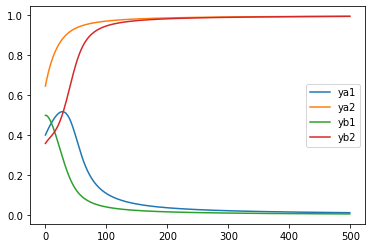

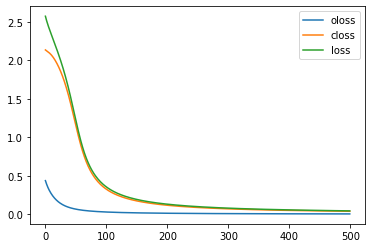

In [4]:
from itertools import chain

neta = Net()
netb = Net()

opt = torch.optim.SGD(chain(neta.parameters(), netb.parameters()), lr=0.1)
plot = PlotHelper()
plot_loss = PlotHelper()


# y: 3, Bx3
def xor(a, b):
    # return (y[0] and not y[2]) or (not y[0] and y[2])
    return a[2]!=b[1] and b[1]!=b[2] and b[2]!=a[1]
    # return any([y[i]==y[i-1] for i in range(10)])

# xor_cons = constraint(xor)
num_samples = 100
# xor_cons = constraint(xor, SamplingSolver(num_samples))
# xor_cons = constraint(xor, WeightedSamplingSolver(num_samples))
xor_cons = constraint(xor, ProductTNormLogicSolver())
# x: 1 -> Bx1
for _ in range(500):
    opt.zero_grad()
    ya_logit = neta(x)
    yb_logit = netb(x)
    oloss = F.cross_entropy(ya_logit[2:], y[2:])
    closs = xor_cons(ya_logit, yb_logit)
    loss = oloss + closs
    loss.backward()
    ya_prob = torch.softmax(ya_logit, dim=-1)
    yb_prob = torch.softmax(yb_logit, dim=-1)
    plot.add(
        ya1=ya_prob[1,1].data, ya2=ya_prob[2,1].data, 
        yb1=yb_prob[1,1].data, yb2=yb_prob[2,1].data)
    plot_loss.add(oloss=oloss.data, closs=closs.data, loss=loss.data)
    opt.step()

plot.show()
plot_loss.show()

In [5]:
import torch
logits_x = torch.tensor([[-2.,2.],[-2.,2.],[2.,-2.]])
c=0.5
logits_y = torch.tensor([[-c,-c,4*c],[-c,-c, c],[c, c, -c]])

def test(x, y): return all(y[x==0]==2 or x[y==2]==1)

cons = constraint(test, ProductTNormLogicSolver())

print('x', torch.softmax(logits_x, dim=-1))
print('y', torch.softmax(logits_y, dim=-1))

cons(logits_x, logits_y)

lambda x,y: ; return ForAll(Or(Eq(y[Eq(x,0)],2),Eq(x[Eq(y,2)],1)))
x tensor([[0.0180, 0.9820],
        [0.0180, 0.9820],
        [0.9820, 0.0180]])
y tensor([[0.0705, 0.0705, 0.8590],
        [0.2119, 0.2119, 0.5761],
        [0.4223, 0.4223, 0.1554]])


tensor(0.1354)